# 1. Import Libraries

In [1]:
from Historic_Crypto import HistoricalData as HD
import pandas as pd
import requests
import json
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
# import scipy
# import textwrap
# import numpy as np
# from statistics import median, mean

# `***** DATA COLLECTION *****`

# 2. Collect Crypto Wallet Transactions Data using Etherscan API

In [2]:
def etherScanAPICall(wallet_address):
    API_KEY = 'JATAZ8XWIBGBTY15YJJEABCDPIF8SCK7S3'
    MATIC_CONTRACT_ADDRESS = '0x7D1AfA7B718fb893dB30A3aBc0Cfc608AaCfeBB0'
    # WALLET_ADDRESS = '0x9507c04b10486547584c37bcbd931b2a4fee9a41'
    url = 'https://api.etherscan.io/api?'

    parameters = {
        'module':'account',
        'action':'tokentx',
        'contractaddress':MATIC_CONTRACT_ADDRESS,
        'address':wallet_address,
        'page':'1',
        'offset':'10000',
        'startblock':'0',
        'endblock':'27025780',
        'sort':'asc',
        'apikey':API_KEY
    }

    responseJSON = requests.request("GET", url, params=parameters).json()

    print("# of Transactions:",len(responseJSON.get("result")))

    # with open("transactionsResponse.json", "w") as write_file:
    #     json.dump(responseJSON, write_file, indent=4, sort_keys = True)

    return responseJSON

In [3]:
listOfWallets = [
    '0x9507c04b10486547584c37bcbd931b2a4fee9a41',
    '0x5666ed92c83af9dab61601c87bf7769ad57103f9',
    '0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0',
    '0xed28b1c47375cd23aa6428544f4feaeaf3ee4e7b',
    '0xf977814e90da44bfa03b6295a0616a897441acec',
    '0xb72b8c812376b5f8436d6854d41646a88aa88422',
    '0x885f16e177d45fc9e7c87e1da9fd47a9cfce8e13',
    '0x4c569c1e541a19132ac893748e0ad54c7c989ff4'
]

In [4]:
def etherScanAPI_MultiWallet_Call(listOfWalletAddresses):

    totalTransactionDataList = []

    for wallet in listOfWalletAddresses:
        walletTransactionData = etherScanAPICall(wallet)
        totalTransactionDataList = totalTransactionDataList + walletTransactionData.get("result")

    return totalTransactionDataList

In [5]:
rawTransactionData = etherScanAPI_MultiWallet_Call(listOfWallets)

# of Transactions: 2901
# of Transactions: 739
# of Transactions: 507
# of Transactions: 3
# of Transactions: 220
# of Transactions: 6
# of Transactions: 245
# of Transactions: 4


# 3. Create Initial Dataframe of Transaction Data

In [6]:
def createTransactionsData_df(rawTransactionData):

    # Create a DataFrame from the list of dictionaries
    rawTransactionData_df = pd.DataFrame(rawTransactionData)

    rawTransactionData_df = rawTransactionData_df.sort_values("timeStamp")
    rawTransactionData_df = rawTransactionData_df.reset_index(drop=True)

    rawTransactionData_df = rawTransactionData_df.drop('nonce', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('tokenName', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('tokenDecimal', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('input', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('confirmations', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('transactionIndex', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('blockNumber', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('hash', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('blockHash', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('gasUsed', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('cumulativeGasUsed', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('contractAddress', axis=1)

    # Print the names of all the columns in the dataframe
    # print(rawTransactionData_df.columns)

    return rawTransactionData_df

In [7]:
rawTransactionData_df = createTransactionsData_df(rawTransactionData)

# 4. Get Start and End Date from Transactions Data

In [8]:
def convert_UNIX_to_DateTime(unix):
    return datetime.utcfromtimestamp(int(unix)).strftime('%Y-%m-%d %H:%M:%S') # 

In [9]:
def getStartAndEndDate(rawTransactionData_df):
    # Get the first row of the dataframe
    startDate_UNIX = rawTransactionData_df.loc[0, "timeStamp"]
    # Get the last row of the dataframe
    endDate_UNIX = rawTransactionData_df.loc[len(rawTransactionData_df.index)-1, "timeStamp"]

    startDate = str(convert_UNIX_to_DateTime(startDate_UNIX))[0:10]
    endDate = str(convert_UNIX_to_DateTime(endDate_UNIX))[0:10]

    return startDate, endDate

In [10]:
startDate, endDate = getStartAndEndDate(rawTransactionData_df)

# 5. Collect Historical Crypto Price Data

In [11]:
def getCryptoHistoricalData(token, startDate, endDate):
    data = HD(token,86400,startDate+"-00-00",endDate+"-00-00").retrieve_data()
    # data.to_csv('tokenPriceData.csv')
    data = data.reset_index(drop=False)
    data['volume'] = data['volume'].astype(float)
    return data

In [12]:
tokenPriceData_df = getCryptoHistoricalData("MATIC-USD", startDate, endDate)

Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'MATIC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2019-08-07T00:00:00
Provisional End: 2020-06-02T00:00:00
Data for chunk 1 of 5 extracted
CoinBase Pro API did not have available data for 'MATIC-USD' beginning at 2019-08-07-00-00.  
                        Trying a later date:'2019-08-07T00:00:00'
Provisional Start: 2020-06-02T00:00:00
Provisional End: 2021-03-29T00:00:00
Data for chunk 2 of 5 extracted


/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Provisional Start: 2021-03-29T00:00:00
Provisional End: 2022-01-23T00:00:00
Data for chunk 3 of 5 extracted
Provisional Start: 2022-01-23T00:00:00
Provisional End: 2022-11-19T00:00:00
Data for chunk 4 of 5 extracted
Provisional Start: 2022-11-19T00:00:00
Provisional End: 2023-09-15T00:00:00
Data for chunk 5 of 5 extracted


/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


In [13]:
print(tokenPriceData_df.head())

        time     low    high    open   close       volume
0 2021-03-11  0.3140  0.5900  0.3871  0.4243  226442305.9
1 2021-03-12  0.3924  0.5376  0.4249  0.4149  399949092.9
2 2021-03-13  0.4097  0.4694  0.4146  0.4249  173058984.7
3 2021-03-14  0.3727  0.4385  0.4263  0.3812  118930211.9
4 2021-03-15  0.3781  0.4300  0.3812  0.3909  115608670.0


# `***** DATA ORGANIZATION AND MERGING *****`

# 6. Add date column to Historical Crypto Dataframe

In [14]:
def addDateColumnToTokenPriceDataframe(tokenPriceData_df):
    tokenPriceData_df.insert(1, 'date', 0)

    for index, row in tokenPriceData_df.iterrows():
        date = str(row["time"])[0:10]
        tokenPriceData_df.loc[index, "date"] = date

    tokenPriceData_df = tokenPriceData_df.drop('time', axis=1)

    return tokenPriceData_df

In [15]:
tokenPriceData_df = addDateColumnToTokenPriceDataframe(tokenPriceData_df)

# 7. Orient dates and corresponding data across Historical Crypto Data and Transactions Data

In [16]:
def orientDatesAndCorrespondingData(tokenPriceData_df, startDate, rawTransactionData_df): 
    startDate2 = str(tokenPriceData_df.loc[0, "date"]) + " 00:00:00"
    # print(startDate2)

    # Define a format string for the date and time
    date_time_fmt = "%Y-%m-%d %H:%M:%S"
    # Convert the string to a datetime object
    startDate2 = datetime.strptime(startDate2, date_time_fmt)

    # Print the datetime object
    # print(startDate2)

    # convert the datetime object into a Unix timestamp
    startDate2_UNIX = time.mktime(startDate2.timetuple())

    # print(startDate_UNIX)
    # print(startDate2_UNIX)

    startDate = str(startDate) + " 00:00:00"
    # print(startDate)
    startDate1 = datetime.strptime(startDate, date_time_fmt)
    startDate1_UNIX = time.mktime(startDate1.timetuple())

    # print(startDate, startDate1_UNIX)

    # The transactions start date is later than the crypto data start date
    if int(startDate1_UNIX) > int(startDate2_UNIX):
        startDate_main_UNIX = startDate1_UNIX

    # The transactions start date is earlier than the crypto data start date
    else:
        startDate_main_UNIX = startDate2_UNIX

    # print the Unix timestamp
    # print(startDate_main_UNIX)

    endDate = tokenPriceData_df.loc[len(tokenPriceData_df.index)-1, "date"]
    # print(endDate)

    rawTransactionData_df['timeStamp'] = rawTransactionData_df['timeStamp'].astype(float)

    rawTransactionData_df = rawTransactionData_df.drop(rawTransactionData_df.index[rawTransactionData_df.loc[:, 'timeStamp'] < startDate_main_UNIX])

    rawTransactionData_df = rawTransactionData_df.reset_index(drop=True)

    return rawTransactionData_df

In [17]:
rawTransactionData_df = orientDatesAndCorrespondingData(tokenPriceData_df, startDate, rawTransactionData_df)

# 8. Add Specified Columns to Transactions Dataframe
- date column
- buy and sell column
- value movement column
- total gas cost column

In [18]:
def addColumns_dateBuySellValueMovementTotalGasCost(rawTransactionData_df, listOfWallets):

    # Adding data column
    rawTransactionData_df.insert(1, 'date', 0)
    for index, row in rawTransactionData_df.iterrows():
        date = convert_UNIX_to_DateTime(row["timeStamp"])[0:10]
        rawTransactionData_df.loc[index, "date"] = date

    # Adding valueMovement and tradeType columns
    rawTransactionData_df.insert(4, 'valueMovement', 0)
    rawTransactionData_df.insert(5, 'tradeType', 0)

    for index, row in rawTransactionData_df.iterrows():
        tradeType = "n/a"
        # considered a BUY
        if row["to"] in listOfWallets:
            valueMovement = int(row["value"])/(10**18)
            tradeType = "BUY"
        # considered a SELL
        elif row["from"] in listOfWallets:
            valueMovement = -1 * (int(row["value"])/(10**18))
            tradeType = "SELL"

        rawTransactionData_df.loc[index, "valueMovement"] = valueMovement
        rawTransactionData_df.loc[index, "tradeType"] = tradeType

    rawTransactionData_df = rawTransactionData_df.drop('value', axis=1)

    # Adding totalGasCost column
    rawTransactionData_df.insert(9, 'totalGasCost', 0)

    for index, row in rawTransactionData_df.iterrows():
        totalGasCost = int(row['gas']) * int(row['gasPrice'])
        rawTransactionData_df.loc[index, "totalGasCost"] = totalGasCost

    return rawTransactionData_df

In [19]:
rawTransactionData_df = addColumns_dateBuySellValueMovementTotalGasCost(rawTransactionData_df, listOfWallets)

# 9. Typecast Data in Transactions Datafame

In [20]:
def typeCastDateIn_rawTransactionData_df(rawTransactionData_df):
    # convert the column to dataTypes
    rawTransactionData_df['date'] = rawTransactionData_df['date'].astype(str)

    rawTransactionData_df['valueMovement'] = rawTransactionData_df['valueMovement'].astype(int)

    rawTransactionData_df['gas'] = rawTransactionData_df['gas'].astype(float)

    rawTransactionData_df['gasPrice'] = rawTransactionData_df['gasPrice'].astype(float)

    rawTransactionData_df['totalGasCost'] = rawTransactionData_df['totalGasCost'].astype(int)

    return rawTransactionData_df

In [21]:
rawTransactionData_df = typeCastDateIn_rawTransactionData_df(rawTransactionData_df)

# 10. Add Specified Columns to Transactions Dataframe
- MATIC price USD column
- total cost USD column
- open-close daily column
- high-low daily column

In [22]:
def addColumns_maticPriceTotalCostOCHL(rawTransactionData_df, tokenPriceData_df):

    # Adding priceUSD column
    rawTransactionData_df.insert(7, 'priceUSD', 0)

    for index, row in rawTransactionData_df.iterrows():
        # print("ran...")
        date = rawTransactionData_df.loc[index, "date"]
        # print("date:", date)
        dateRow_df = tokenPriceData_df.loc[tokenPriceData_df['date'] == date]
        # print("dateRow:\n", dateRow_df)
        dateRow_df = dateRow_df.reset_index(drop=True)
        price = (float(dateRow_df.loc[0, "open"]) + float(dateRow_df.loc[0, "close"]))/2
        # print("price:", price)

        rawTransactionData_df.loc[index, "priceUSD"] = price

    # Adding totalCostUSD column
    rawTransactionData_df.insert(8, 'totalCostUSD', 0)

    for index, row in rawTransactionData_df.iterrows():
        totalCost = float(row["valueMovement"]) * float(row["priceUSD"])
        rawTransactionData_df.loc[index, "totalCostUSD"] = totalCost

    # Adding OCdailyPriceMovementUSD and HLdailyPriceMovementUSD scolumn
    rawTransactionData_df.insert(9, 'OCdailyPriceMovementUSD', 0)
    rawTransactionData_df.insert(10, 'HLdailyPriceMovementUSD', 0)

    for index, row in rawTransactionData_df.iterrows():

        date = rawTransactionData_df.loc[index, "date"]

        maticPrice_df = tokenPriceData_df.loc[tokenPriceData_df['date'] == date]
        maticPrice_df = maticPrice_df.reset_index(drop=True)

        open = maticPrice_df.loc[0, "open"]
        close = maticPrice_df.loc[0, "close"]
        high = maticPrice_df.loc[0, "high"]
        low = maticPrice_df.loc[0, "low"]
        
        OCprice = open - close
        HLprice = high - low

        rawTransactionData_df.loc[index, "OCdailyPriceMovementUSD"] = OCprice
        rawTransactionData_df.loc[index, "HLdailyPriceMovementUSD"] = HLprice

    rawTransactionData_df = rawTransactionData_df.sort_values("timeStamp")
    rawTransactionData_df = rawTransactionData_df.reset_index(drop=True)

    return rawTransactionData_df

In [23]:
rawTransactionData_df = addColumns_maticPriceTotalCostOCHL(rawTransactionData_df, tokenPriceData_df)

In [24]:
# Output the DataFrame to a CSV file
rawTransactionData_df.to_csv('rawTransactionData_df.csv', index=True)

# 11. Create Transactions Volume Dataframe

In [25]:
def createTransactionVolumeDF(rawTransactionData_df, tokenPriceData_df):

    datesList = tokenPriceData_df['date'].to_list()
    # print(len(datesList))
    # print(datesList[0:5])

    # Columns: -Index, #Date, *Num Transactions, *Value Movement, *Num BUYS, *Num Sells, *MATIC Price USD, -Total Cost USD, *OC daily price, *HL daily price

    dateToDailyTransactionInfoDict = {}

    for date in datesList:

        transaction_df = rawTransactionData_df.loc[rawTransactionData_df['date'] == date]
        transaction_df = transaction_df.reset_index(drop=True)

        # print("transaction_df\n", transaction_df, "\nend df...")

        if not transaction_df.empty:

            # loop through every row in the DataFrame and print the values
            for index, row in transaction_df.iterrows():

                valueMoved = row["valueMovement"]
                tradeType = row["tradeType"]

                if tradeType == "BUY":
                    buy = 1
                    sell = 0
                else: 
                    sell = 1
                    buy = 0

                if date not in dateToDailyTransactionInfoDict.keys():
                    # print('run if..')
                    dateToDailyTransactionInfoDict[date] = [1, valueMoved, buy, sell]

                # elif date in dateToDailyTransactionInfoDict.keys():
                else:
                    # print('run elif..')
                    currentTransactionInfo = dateToDailyTransactionInfoDict.get(date)

                    currentNumTransactions = int(currentTransactionInfo[0]) + 1
                    currentValueMoved = currentTransactionInfo[1] + valueMoved
                    currentBuyNum = currentTransactionInfo[2] + buy
                    currentSellNum = currentTransactionInfo[3] + sell

                    dateToDailyTransactionInfoDict[date] = [currentNumTransactions, currentValueMoved, currentBuyNum, currentSellNum]

                # print(date, dateToDailyTransactionInfoDict.get(date))

        else:

            dateToDailyTransactionInfoDict[date] = [0, 0, 0, 0]

        # print(date, dateToDailyTransactionInfoDict.get(date))

    # create an empty list to store the lists
    dateToDailyTransactionInfoList = []

    # iterate over the dictionary's items and create a new list with the key as the first element and the value as the second element
    for key, value in dateToDailyTransactionInfoDict.items():
        dateToDailyTransactionInfoList.append([key, value[0], value[1], value[2], value[3]])

    columnNames = ["date", "numTransactions", "valueMoved", "buyNum", "sellNum"]
    timeSeriesTransactionData_df = pd.DataFrame(dateToDailyTransactionInfoList, columns=columnNames)

    maticPriceUSD = (tokenPriceData_df["open"] + tokenPriceData_df["close"])/2
    volume = list(tokenPriceData_df["volume"])

    timeSeriesTransactionData_df["MaticPriceUSD"] = maticPriceUSD
    timeSeriesTransactionData_df["volume"] = volume

    return timeSeriesTransactionData_df

In [26]:
timeSeriesTransactionData_df = createTransactionVolumeDF(rawTransactionData_df, tokenPriceData_df)

In [27]:
# Output the DataFrame to a CSV file
timeSeriesTransactionData_df.to_csv('timeSeriesTransactionData_df.csv', index=True)

# `***** DATA ANALYSIS AND VISUALIZATIONS *****`

`Linear Regression`

In [28]:
def performLinearRegression(data1, data2):
    a = data1
    b = data2

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(a, b)
    
    print("R_value:",r_value**2)
    print("P_value:",p_value)

`scatter plot`
- input: two lists of values
- output: scatter plot with linear regression line
- returns r value and p value

In [29]:
def create_scatter_plot(data1, data2, title, xlabel, ylabel, figureText):

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.figtext(0.5, -0.2, figureText, wrap=True, horizontalalignment='center', fontsize=12)

    # Use seaborn to plot the scatter plot
    sns.scatterplot(data1, data2)
    # Fit a regression line to the data and plot it on the scatter plot
    sns.regplot(data1, data2)

    plt.savefig("visualizations/"+title+".png", dpi=300, bbox_inches = "tight")

    # Show the plot
    plt.show()

    performLinearRegression(data1, data2)

`overlapping line graph`
- input: two lists of values
- output: line graph with overlapping lines in different colors

In [30]:
def create_line_plot(data1, data1Label, data2, data2Label, title, xlabel, ylabel, figureText):

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.figtext(0.5, -0.2, figureText, wrap=True, horizontalalignment='center', fontsize=12)

    # Create the plot
    plt.plot(data1, color="orange", label=data1Label)
    plt.plot(data2, color="blue", label=data2Label)

    # Add a legend to the plot
    plt.legend()

    # add a description to the graph
    # text = textwrap.wrap(description, width=40)
    # plt.text(0, 20,'\n'.join(text), fontsize=10, ha='left', va='bottom')

    # plots bar chart of keys (x) against values (y)
    plt.savefig("visualizations/"+title+".png", dpi=300, bbox_inches = "tight")

`Data to Analyze`

In [31]:
def getDataForVisualizations(rawTransactionData_df,timeSeriesTransactionData_df):

    # rawTransactionData_df
    maticPriceUSD = list(rawTransactionData_df["priceUSD"])

    gasPriceUSD = list(rawTransactionData_df["gasPrice"])

    numGas = list(rawTransactionData_df["gas"])
    numGas = [float(abs(x)) for x in numGas]

    OCdailyPrice = list(rawTransactionData_df["OCdailyPriceMovementUSD"])
    ABSOCdailyPrice = [float(abs(x)) for x in OCdailyPrice]

    HLdailyPrice = list(rawTransactionData_df["HLdailyPriceMovementUSD"])

    totalCostUSD = list(rawTransactionData_df["totalCostUSD"])
    ABStotalCostUSD = [float(abs(x)) for x in totalCostUSD]

    gasPrice = list(rawTransactionData_df["gasPrice"])

    # timeSeriesTransactionData_df
    maticPriceUSDv2 = list(timeSeriesTransactionData_df["MaticPriceUSD"])
    maticPriceUSDx100000000 = [(float(x)*100000000) for x in maticPriceUSDv2]

    volume = list(timeSeriesTransactionData_df["volume"])

    ABSValueMovedUSD = list(timeSeriesTransactionData_df["valueMoved"])
    ABSValueMovedUSD = [float(abs(x)) for x in ABSValueMovedUSD]

    buyNum = list(timeSeriesTransactionData_df["buyNum"])

    sellNum = list(timeSeriesTransactionData_df["sellNum"])

    return maticPriceUSD, gasPriceUSD, numGas, OCdailyPrice, ABSOCdailyPrice, HLdailyPrice, totalCostUSD, ABStotalCostUSD, gasPrice, maticPriceUSDv2, maticPriceUSDx100000000, volume, ABSValueMovedUSD, buyNum, sellNum

In [32]:
maticPriceUSD, gasPriceUSD, numGas, OCdailyPrice, ABSOCdailyPrice, HLdailyPrice, totalCostUSD, ABStotalCostUSD, gasPrice, maticPriceUSDv2, maticPriceUSDx100000000, volume, ABSValueMovedUSD, buyNum, sellNum = getDataForVisualizations(rawTransactionData_df,timeSeriesTransactionData_df)

`Plotting and Graph Visualizations`

rawTransactionData_df
- Total Cost Purchased USD VS MATIC Price USD
- MATIC Price USD VS Gas Price
- Total Cost Purchased USD VS Num Gas
- Total Cost Purchased USD VS OC Daily Price
- Total Cost Purchased USD [ABS] VS HL Daily Price
- HL Daily Price VS OC Daily Pricex

In [33]:
# print(rawTransactionData_df.columns)

/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


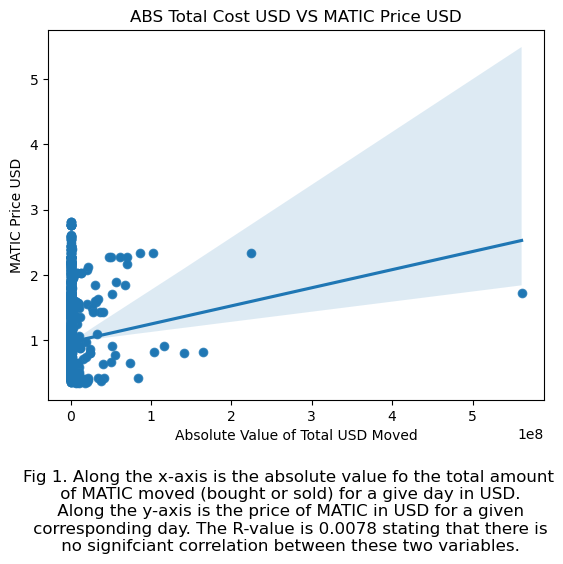

R_value: 0.007774793700313935
P_value: 2.81659726361617e-09


In [34]:
create_scatter_plot(ABStotalCostUSD, maticPriceUSD, "ABS Total Cost USD VS MATIC Price USD", "Absolute Value of Total USD Moved", "MATIC Price USD", 
"Fig 1. Along the x-axis is the absolute value fo the total amount\n of MATIC moved (bought or sold) for a give day in USD.\n Along the y-axis is the price of MATIC in USD for a given\n corresponding day. The R-value is 0.0078 stating that there is\n no signifciant correlation between these two variables.")

/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


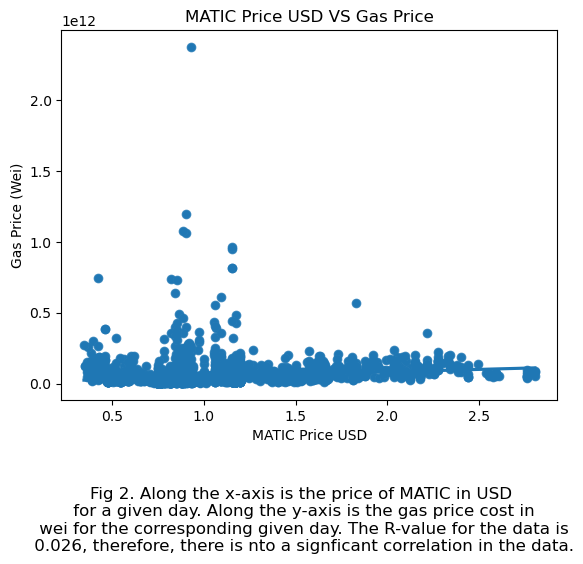

R_value: 0.02564391238241837
P_value: 2.215818506329367e-27


In [35]:
create_scatter_plot(maticPriceUSD, gasPriceUSD, "MATIC Price USD VS Gas Price", "MATIC Price USD", "Gas Price (Wei)", 
"Fig 2. Along the x-axis is the price of MATIC in USD\n for a given day. Along the y-axis is the gas price cost in\n wei for the corresponding given day. The R-value for the data is\n 0.026, therefore, there is nto a signficant correlation in the data.")

/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


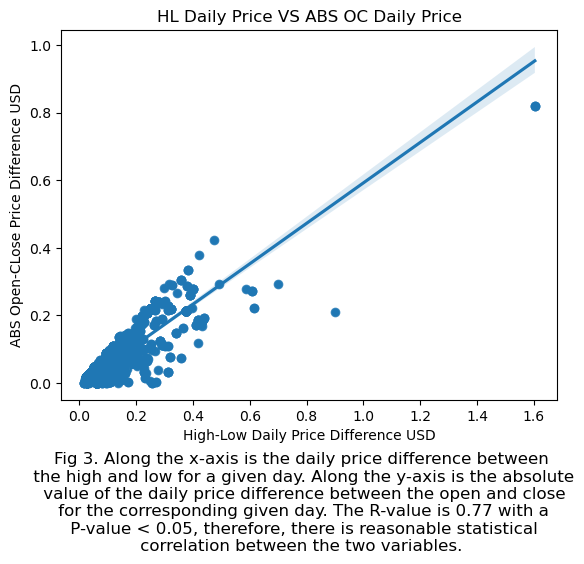

R_value: 0.7730969130540443
P_value: 0.0


In [36]:
create_scatter_plot(HLdailyPrice, ABSOCdailyPrice, "HL Daily Price VS ABS OC Daily Price", "High-Low Daily Price Difference USD", "ABS Open-CLose Price Difference USD", 
"Fig 3. Along the x-axis is the daily price difference between\n the high and low for a given day. Along the y-axis is the absolute\n value of the daily price difference between the open and close\n for the corresponding given day. The R-value is 0.77 with a\n P-value < 0.05, therefore, there is reasonable statistical\n correlation between the two variables. ")

/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


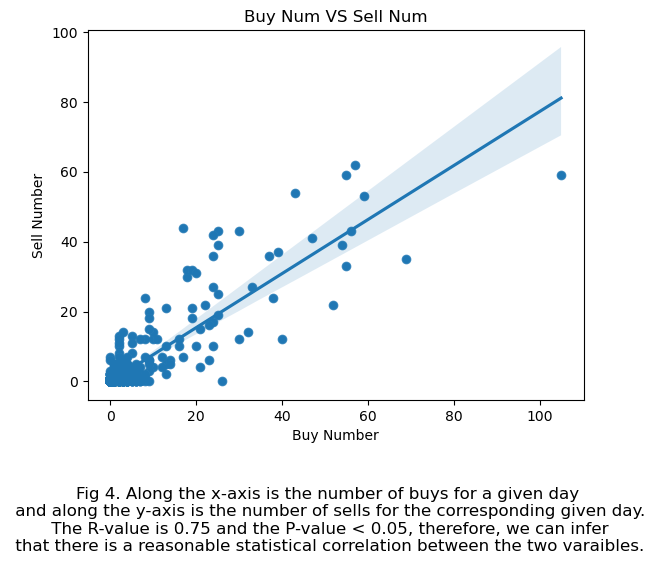

R_value: 0.7484404531490798
P_value: 1.4668862339361588e-194


In [37]:
create_scatter_plot(buyNum, sellNum, "Buy Num VS Sell Num Scatter Plot", "Buy Number", "Sell Number", 
"Fig 4. Along the x-axis is the number of buys for a given day\n and along the y-axis is the number of sells for the corresponding given day.\n The R-value is 0.75 and the P-value < 0.05, therefore, we can infer\n that there is a reasonable statistical correlation between the two varaibles.")

timeSeriesTransactionData_df
- Matic Price USD VS Volume
- Matic Price VS ABS Value Moved USD
- Buy Num vs Sell Num

In [38]:
# print(timeSeriesTransactionData_df.columns)

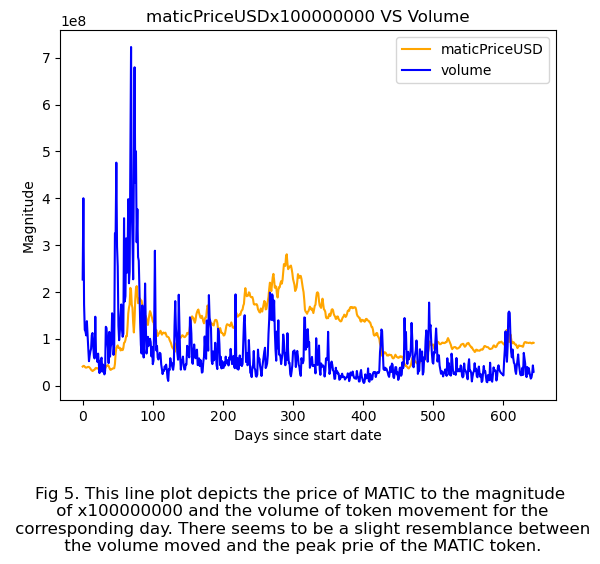

In [39]:
create_line_plot(maticPriceUSDx100000000, "maticPriceUSD", volume, "volume", "maticPriceUSDx100000000 VS Volume", "Days since start date", "Magnitude", 
"Fig 5. This line plot depicts the price of MATIC to the magnitude\n of x100000000 and the volume of token movement for the\n corresponding day. There seems to be a slight resemblance between\n the volume moved and the peak prie of the MATIC token.")

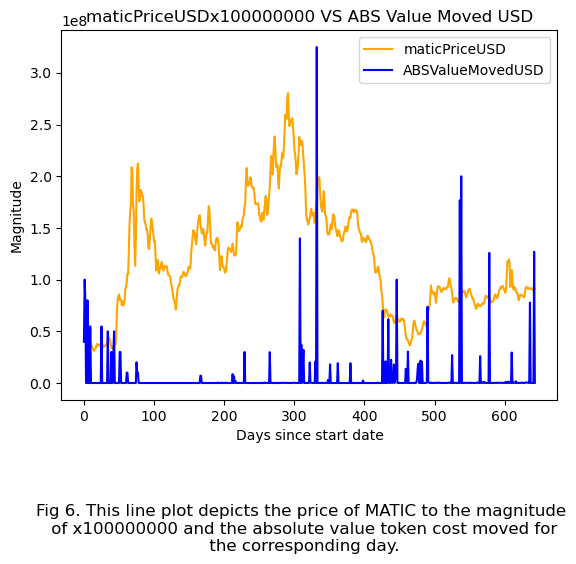

In [40]:
create_line_plot(maticPriceUSDx100000000, "maticPriceUSD", ABSValueMovedUSD, "ABSValueMovedUSD", "maticPriceUSDx100000000 VS ABS Value Moved USD", "Days since start date", "Magnitude", 
"Fig 6. This line plot depicts the price of MATIC to the magnitude\n of x100000000 and the absolute value token cost moved for\n the corresponding day.")

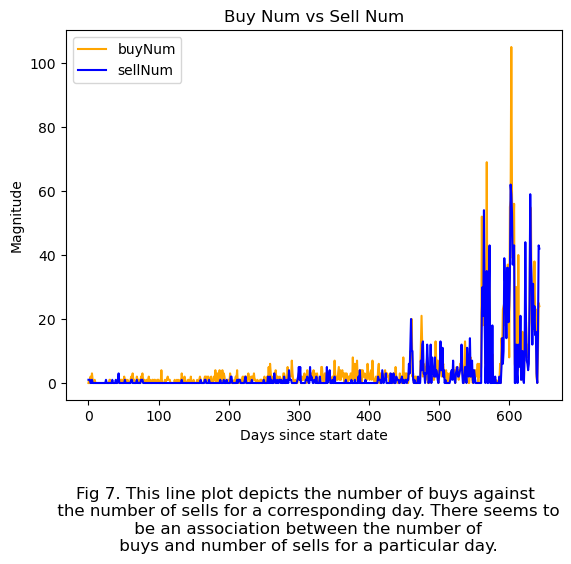

In [41]:
create_line_plot(buyNum, "buyNum", sellNum, "sellNum", "Buy Num vs Sell Num", "Days since start date", "Magnitude", 
"Fig 7. This line plot depicts the number of buys against\n the number of sells for a corresponding day. There seems to\n be an association between the number of\n buys and number of sells for a particular day.")